# Step 1: Load and explore the dataset
From the following link, because there wasn't a file with a .csv option available, I downloaded the option with the .sav extension after checking pandas to have a read_spss() method built-in available:
https://gss.norc.org/Get-The-Data

Then I used the .columns attribute and .describe() method to find out that I have a dataset that has many columns and rows and I found an online documentation & codebook to see what each column represents and to navigate more smoothly through the data analysis. Here is the link to the codebook: https://gss.norc.org/Documents/codebook/GSS%202022%20Codebook.pdf

I also checked for missing values and since almost 50% of all values were missing I decided it would make much more sense to specifically look at the missing values for each key variable I'm interested in, because accounting for the half of the missing values throughout the entire set would probably take me a very long time and since I won't be using much of it, it would be reduntant labor

In [5]:
import pandas as pd
import seaborn as sns

dataset = pd.read_spss("/Users/cem/Desktop/KU/SOCI354/Assignments/Assignment Datasets/GSS2018.sav")
print(dataset.columns)
print(dataset.describe())

missing_cells = dataset.isna().sum().sum()
total_cells = dataset.size

print("Number of missing cells:", missing_cells)
print("Number of total cells:", total_cells)
print(f"Percentage of missing cells: {missing_cells/total_cells:.3f}")

Index(['ABANY', 'ABDEFECT', 'ABFELEGL', 'ABHELP1', 'ABHELP2', 'ABHELP3',
       'ABHELP4', 'ABHLTH', 'ABINSPAY', 'ABMEDGOV1',
       ...
       'XMARSEX', 'XMARSEX1', 'XMOVIE', 'XNORCSIZ', 'YEAR', 'YEARSJOB',
       'YEARSUSA', 'YEARVAL', 'YOUSUP', 'ZODIAC'],
      dtype='object', length=1065)
       FORMWT           ID  OVERSAMP      VERSION    YEAR
count  2348.0  2348.000000    2348.0  2348.000000  2348.0
mean      1.0  1174.500000       1.0     2.001704  2018.0
std       0.0   677.953538       0.0     0.818926     0.0
min       1.0     1.000000       1.0     1.000000  2018.0
25%       1.0   587.750000       1.0     1.000000  2018.0
50%       1.0  1174.500000       1.0     2.000000  2018.0
75%       1.0  1761.250000       1.0     3.000000  2018.0
max       1.0  2348.000000       1.0     3.000000  2018.0
Number of missing cells: 1217785
Number of total cells: 2500620
Percentage of missing cells: 0.487


# Step 2: Descriptive statistics

Here is a list of each I variable I chose along with their explanation in the codebook:
- EDUC: Respondent's education
- SEX: Respondent's sex
- TVHOURS: On the average day, about how many hours do you personally watch television?

I decided to discard a row if any of the variable's value is missing since there is not a straightforward way to replace them meaningfully without applying some sort of an advanced technique to handle missing datas (for example, run a regression with what you have to have a rough estimate of what the TVHOURS value would be across the given EDUC range for a specific SEX and replace each NaN with that)

<Axes: >

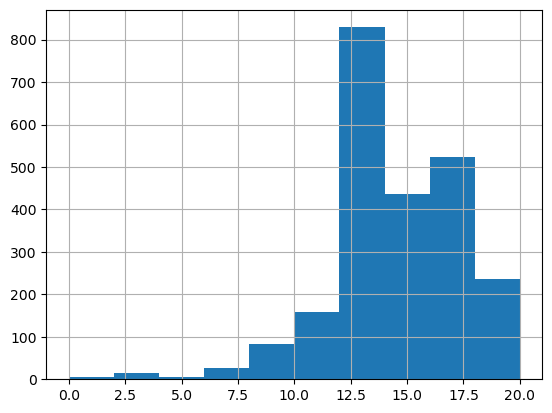

In [18]:
dataset["EDUC"].hist()

<Axes: >

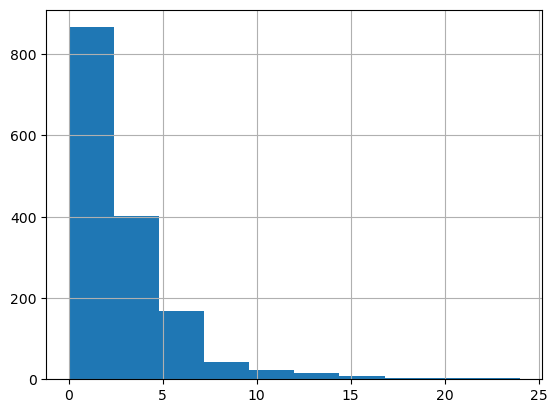

In [19]:
dataset["TVHOURS"].hist()

<Axes: >

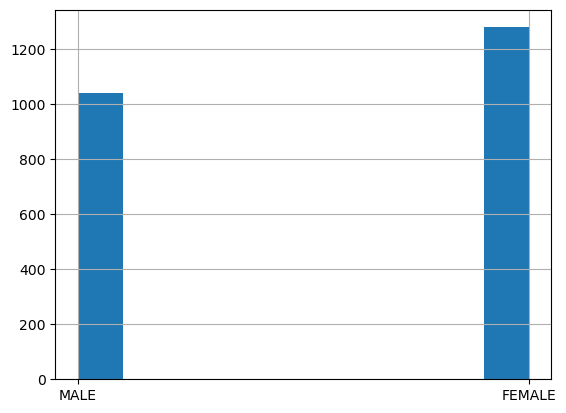

In [20]:
dataset["SEX"].hist()

In [23]:
# Create a new dataframe with only the relevant variables
new_df = pd.DataFrame(dataset, columns=["SEX","EDUC","TVHOURS"])

# Drop all rows where any column has a missing value
new_df = new_df.dropna(axis='rows', how="any")

# Convert the variable's type to appropriate types
new_df["EDUC"] = new_df["EDUC"].astype(float)
new_df["TVHOURS"] = new_df["TVHOURS"].astype(float)

# Description table for the numeric variables
print(new_df.describe().round(2))
print("---")
# Description table for the categorical variables
print(new_df["SEX"].describe())

          EDUC  TVHOURS
count  1533.00  1533.00
mean     13.68     2.91
std       3.00     2.79
min       0.00     0.00
25%      12.00     1.00
50%      13.00     2.00
75%      16.00     4.00
max      20.00    24.00
---
count       1533
unique         2
top       FEMALE
freq         852
Name: SEX, dtype: object


# Step 3: Inferential statistics

I decided to run a t-test to see whether males and females differ in terms of how many hours of TV they watch and their completed years of education. Without running the tests here are my hypotheses:
- I hypothesize that males' years of education completed will be higher than females since, well, patriarchy.
- I hypothesize that there won't be any difference between males and females in the hours of TV they watch because no reason as to why it should comes to my mind.

First, before I conduct the t-tests, I conduct a Levene's test to see if there are any significant differences between both groups' variances to make sure the tests yield insignificant results so I fulfill the assumptions of a t-test.

In [26]:
from scipy import stats

female_educ = new_df[new_df['SEX'] == "FEMALE"]['EDUC']
male_educ = new_df[new_df['SEX'] == "MALE"]['EDUC']
female_tvhours = new_df[new_df['SEX'] == "FEMALE"]['TVHOURS']
male_tvhours = new_df[new_df['SEX'] == "MALE"]['TVHOURS']

print(stats.levene(female_educ, male_educ))
print(stats.levene(female_tvhours, male_tvhours))
#Both are insiginifcant with .87 and .43, so we are good to go!


LeveneResult(statistic=0.028007468667130494, pvalue=0.867113366406139)
LeveneResult(statistic=0.6208166953102052, pvalue=0.4308659286967663)


In [33]:
import statsmodels.stats.api as sms

model = sms.CompareMeans.from_data(new_df[new_df['SEX'] == "FEMALE"]['EDUC'], new_df[new_df['SEX'] == "MALE"]['EDUC'])
model.summary(usevar='pooled')

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-0.0147,0.154,-0.095,0.924,-0.317,0.288


In [34]:
model2 = sms.CompareMeans.from_data(new_df[new_df['SEX'] == "FEMALE"]['TVHOURS'], new_df[new_df['SEX'] == "MALE"]['TVHOURS'])
model2.summary(usevar='pooled')

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,0.1225,0.144,0.853,0.394,-0.159,0.404


It seems like in both cases, I failed to reject the null hypothesis, meaning no stastically significant differences between males and females in the years of education completed or the hours of tv they watch exist.
There is already confidence intervals with α=.025 on each side provided in the table for the t-statistics. If I want to calculate confidence intervals for the means of each sex, I would need to compute the standard error of the mean, multiply that by 1.96, and subtract and add that value to the mean to have a 95%CIs.

# Step 4: Correlation
Let's see if there is any correlation between completed years of education and hours of tv watched. Many reasons as to why there could be a correlation between these variables come to my mind. Here are 3 of them:
- More educated people might be seeking out more information through news channels (positive correlation)
- More educated people might see watching TV as something useless and hence watch less TV (negative correlation)
- Less educated people might need to work longer hours compared to more educated people, hence leaving less spare time to watch TV (negative correlation)

Having said that, there are also reasons why the correlation might be insignificant or nonexistent:
- The positive and negative aspects of the correlation hypotheses above might cancel each other out resulting in a null result. We would need to control for more variables to see whether there is actually a partial correlation between these variables
- Our sample might not be representative of the whole population or biased more towards more or less educated people, distorting the results
- The hypotheses might simply be wrong. And on a similar note, even if they are significant, a correlation does not imply causation so I need to infer cautiously.

<Axes: xlabel='EDUC', ylabel='TVHOURS'>

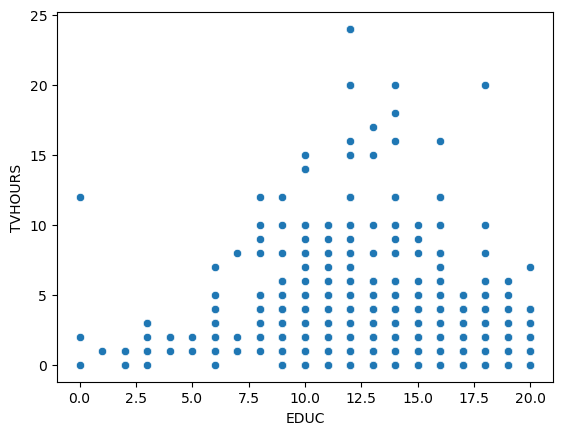

In [53]:
sns.scatterplot(x="EDUC", y="TVHOURS", data=new_df)

By simply looking at the graph, I might expect a positive correlation between the variables but I still need to run proper tests.

In [36]:
stats.pearsonr(new_df['EDUC'], new_df['TVHOURS'])

PearsonRResult(statistic=-0.16800850616828691, pvalue=3.595142796706554e-11)

Interesting enough, even though the correlation is significant, it is the opposite of what I expected. There seems to be a negative correlation between the variables. The reason might be that since I have many overlapping datapoints, it was not possible to see how many individuals were on each dot. Depending on the density for each individual dot on the graph, it is possible to have a negative correlation as well. I also looked at the relationship with the sns.lmplot() method, and it indeed seems like what I thought was correct. 

I added some jitter and additional arguments to the graph to make it better visually using the seaborn documentation (https://seaborn.pydata.org/generated/seaborn.lmplot.html)

/Users/cem/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


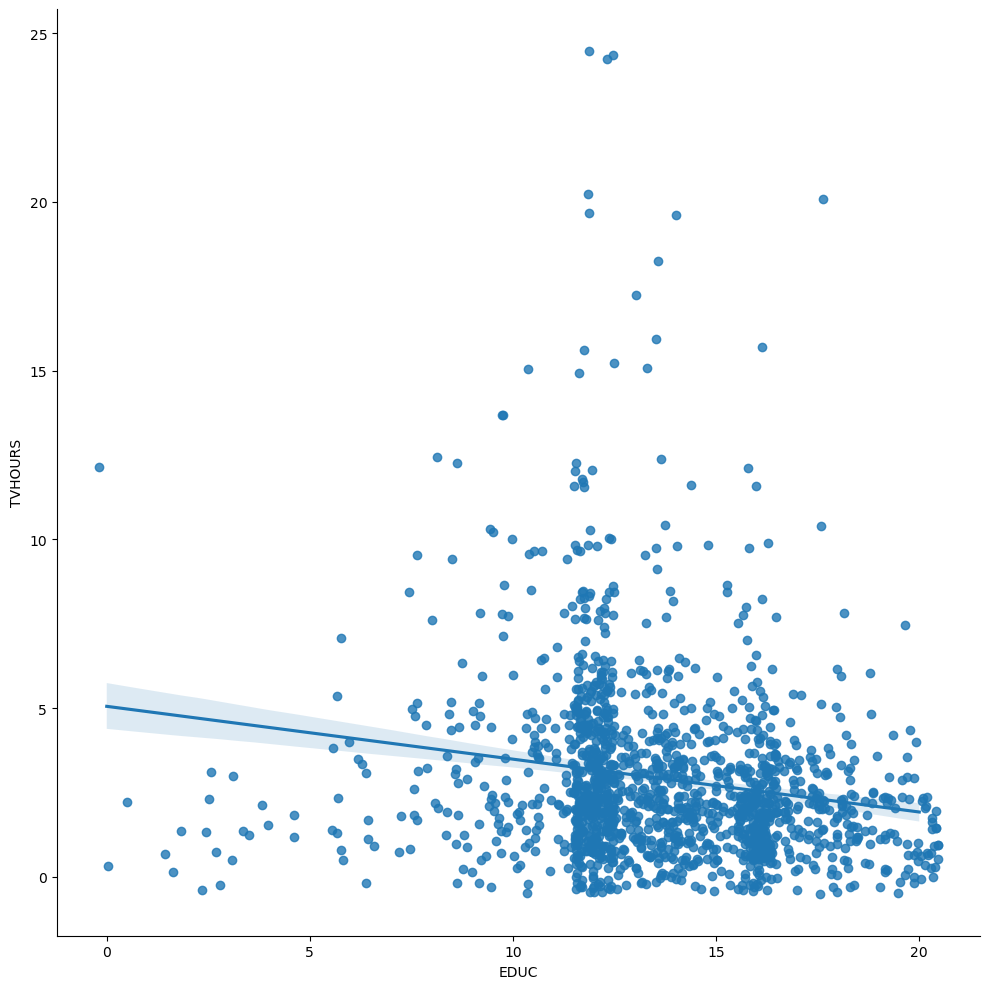

In [52]:
sns.lmplot(x="EDUC", y="TVHOURS", data=new_df, ci=95,x_jitter=.5,y_jitter=.5, height=10)